In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy
import time

from funcs.model import (full_model,
                         aflare,
                         aflare_decoupled,
                         calculate_specific_flare_flux,
                         calculate_angular_radius)
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve


CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve


# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 7, # one flare, one active region
             "log_probability_2flares": 11, # two flares, one active region
            }

# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


In [5]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 3
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                             277539431
QCS                                   12
typ                                  slc
cadence_min                            2
mission                             tess
prefix                               TIC
origin                            custom
h_mission                           TESS
SpT                                   M7
view_start                          1641
view_stop                         1643.5
view_min                             750
view_max                             970
BJDoff                           2457000
tstart                           1641.84
ampl_min                             0.9
ampl_max                             1.7
GRP                                 1.52
plxmas                           72.9672
eplxmas                            0.569
RA                               163.815
Dec                             -73.9364
J                                  10.63
R                                    NaN
Gaia_G          

In [63]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.45 ) & (t < target.view_stop-1.) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03


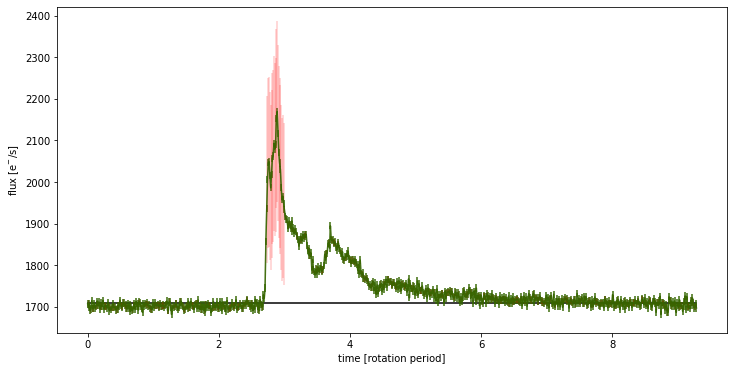

In [64]:
cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf#f#.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
# cff = cff[(cff.phi<2.43*2*np.pi) |(cff.phi>2.55*2*np.pi)]

plt.figure(figsize=(12,6))
#plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="g", alpha=.9)
half = cff.flux > cff.flux.max()/2 + median/2
half2 = cff.loc[cff.phi/(2*np.pi)>0.6, "flux"] > cff.loc[cff.phi/(2*np.pi)>0.6, "flux"].max()/2 + median/2
cff.loc[half | half2,  "flux_err" ] = cff[half | half2].flux *.1
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.2)
efold = (cff.flux > (cff.flux.max()-median)/np.e + median) & (cff.phi/(2*np.pi) < 2.5)
# cff.loc[half,  "flux_err" ] = cff[half].flux *0.3
#plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.2)

plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="k", zorder=1)

plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]");
# plt.ylim(550, 750)

In [65]:
#cff = cff[(cff.phi<18.7) |(cff.phi>19.6)]
cff.flux_err.max(), cff.shape

(216.91475, (756, 5))

In [66]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [67]:
tstamp

'06_11_2020_15_47'

In [6]:
gplc = pd.read_csv(f"{CWD}/data/lcs/04_12_2020_14_18_277539431.csv")
gplc

,phi,flux,t,flux_err,median_
0,0.000000,784.459680,1641.601919,7.270714,780.411071
1,0.045926,788.427499,1641.603308,7.270926,780.411071
2,0.091852,774.154231,1641.604697,7.269866,780.411071
3,0.137778,785.521701,1641.606086,7.279974,780.411071
4,0.183703,784.978135,1641.607475,7.268611,780.411071
...,...,...,...,...,...
1168,54.238435,778.419431,1643.242168,6.898362,780.411071
1169,54.284361,783.178613,1643.243557,6.959084,780.411071
1170,54.330287,782.953756,1643.244946,6.896783,780.411071
1171,54.376213,784.880991,1643.246335,6.907295,780.411071


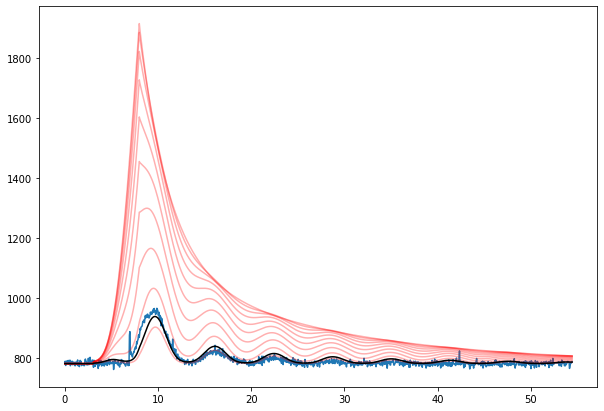

In [16]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =8.
# Active region latitude
theta_a = 1.41

# Flare amplitude
a = 1.5

# 2*FWHM of flare
fwhm1 = 4.96
fwhm2 = 4.96


phi0 =-2.61
i_mu = 1.52 
i_sigma = 0.04

Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
#---------------------------------------

# Flare peak time
# phi_a2 =17.8


# # Flare amplitude
# a2 = .05053675464244

# # 2*FWHM of flare
# fwhm12 = 1.1
# fwhm22 =1.4
#-----------------------------------------
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius

plt.figure(figsize=(10,7))
# plt.plot(cff.phi,cff.flux)
plt.plot(gplc.phi,gplc.flux)
phi= gplc.phi.values
median = gplc.median_.iloc[0]
for i in np.linspace(0,np.pi/2,10):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm1, fwhm2, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,);

#plt.ylim(1650,2000)
#plt.yscale("log")

#  + full_model(phi_a2, theta_a, a2, fwhm12, fwhm22, i, phi0=phi0,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median)-median
    
#     + full_model(phi_a2, theta_a, a2, fwhm12, fwhm22, i_mu, phi0=phi0,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median)-median

In [65]:
# Choose model:
log_prob = "log_probability_2flares"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits_decoupled.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm1,fwhm2,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm1},{fwhm2},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)

In [58]:
10000/5./60

33.333333333333336

In [40]:
5000/3600

1.3888888888888888